# Tâche de Classification des recettes par le type de plat
Auteurs :     
  - BOURDERE ANDREOU Nathan
  - CHUPIN Yannis

## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
!pip install gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.metrics import confusion_matrix
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#!pip uninstall gensim -y
#!pip install gensim==4.3.3
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Pre-processing

### Récupération des données de train et de test

In [4]:
train_data = pd.read_csv('./sample_data/train.csv',encoding="utf-8")
test_data = pd.read_csv('./sample_data/test.csv')
stemmer = SnowballStemmer('french')
stopwords = set(stopwords.words('french'))
print(train_data.shape,test_data.shape)
train_data.head()

(12473, 7) (1388, 7)


,doc_id,titre,type,difficulte,cout,ingredients,recette
0,recette_221358.xml,"Feuilleté de saumon et de poireau, sauce aux c...",Plat principal,Facile,Moyen,- 1 gros pavé de saumon - 100 g de crevettes d...,Couper finement le blanc et un peu de vert des...
1,recette_48656.xml,Cake poulet/moutarde/amandes,Entrée,Très facile,Bon marché,- 3 œufs - 150 g de farine - 1 sachet de levur...,"Couper finement l'échalote, la faire revenir à..."
2,recette_30049.xml,Bûche à la truite fumée (7ème rencontre),Entrée,Moyennement difficile,Assez Cher,- 800 g de filet de truite saumonnée fumée en ...,Faites blanchir les épinards à l'eau bouillant...
3,recette_71424.xml,Gâteau au yaourt au coco sans huile de laetitia,Dessert,Très facile,Bon marché,- 1 pot de yaourt - 1 pot de lait de coco - 3 ...,Mélanger dans l'ordre tous les ingrédients en ...
4,recette_217204.xml,Crêpes au canard laqué,Entrée,Moyennement difficile,Moyen,- 90 g de farine - 45 g de maïzena - 2 œufs - ...,"Fouetter les œufs avec l'eau, le lait et le su..."


### Gestion des valeurs manquantes, concaténation des caractéristiques clés de texte et Pre-processing simple des textes combinés


In [5]:
train_data.dropna(axis=0,inplace=True)
test_data.dropna(axis=0,inplace=True)
text_data = pd.concat([train_data['ingredients'],train_data['recette'],train_data['titre']])
sentences = [simple_preprocess(text) for text in text_data]
data = pd.concat([train_data, test_data])

### Fonction pour afficher une matrice de confusion

In [6]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(cm, text_auto=True, labels=dict(y="True Label", x="Predicted Label"),
                    x=encoder.classes_, y=encoder.classes_, title=title)
    fig.show()

## BASELINE : Prédiction Aléatoire

In [57]:
def prediction_aleatoire(data):
  """Prédit aléatoirement une classe pour chaque ligne du DataFrame.

  Args:
    data: Le DataFrame contenant les données.

  Returns:
    Un array contenant les prédictions pour chaque ligne.
  """
  classes = ['Entrée', 'Plat Principal', 'Dessert']
  nombre_lignes = data.shape[0]
  predictions = np.random.choice(classes, size=nombre_lignes)
  return predictions

In [65]:
pred_baseline = prediction_aleatoire(test_data)

In [72]:
y_test = test_data['type'].values
classification_report(y_test, pred_baseline)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-p

'                precision    recall  f1-score   support\n\n       Dessert       0.31      0.35      0.33       407\n        Entrée       0.24      0.34      0.28       337\nPlat Principal       0.00      0.00      0.00         0\nPlat principal       0.00      0.00      0.00       644\n\n      accuracy                           0.19      1388\n     macro avg       0.14      0.17      0.15      1388\n  weighted avg       0.15      0.19      0.16      1388\n'

## 1ère Approche de Pre-processing : CamemBERT

### Installation de torch nécéssaire

In [7]:
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### Imports nécéssaires à l'utilisation de Camembert

In [8]:
from transformers import CamembertTokenizer, CamembertModel
import torch

### Utilisation du GPU, instantiation du modèle CamemBERT et fonctions de tokenization et vectorization des embeddings de chaque texte ainsi que de combinaison de chaque vecteur sans pondération

In [9]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Charger le tokenizer et le modèle sur le GPU-
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base').to(device)

def get_text_vector_bert(text, model, tokenizer):
    # Tokenization et déplacement sur GPU
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state
    text_vector = torch.mean(embeddings, dim=1).squeeze()

    return text_vector.cpu().numpy()  # Déplacement vers CPU avant conversion en numpy

def get_combined_vector_bert(ingredients, recette, titre, model, tokenizer):
    # Obtenir les vecteurs pour chaque champ de texte
    vector_ingredients = get_text_vector_bert(ingredients, model, tokenizer)
    vector_recette = get_text_vector_bert(recette, model, tokenizer)
    vector_titre = get_text_vector_bert(titre, model, tokenizer)

    # Combiner les vecteurs (ici par addition)
    combined_vector = vector_ingredients + vector_recette + vector_titre

    return combined_vector


cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

### Application des fonctions aux données, Drop des caractéristiques non-clés et création d'une caractéristique comprenant les embeddings de mots

In [10]:
train_data_b= train_data.copy()
test_data_b = test_data.copy()

train_data_b['vector'] = train_data_b.apply(lambda row: get_combined_vector_bert(row['ingredients'], row['recette'], row['titre'], model, tokenizer), axis=1)
test_data_b['vector'] = test_data_b.apply(lambda row: get_combined_vector_bert(row['ingredients'], row['recette'], row['titre'], model, tokenizer), axis=1)

train_data_b = train_data_b.drop(['ingredients', 'recette', 'titre', 'difficulte', 'cout', 'doc_id'], axis=1)
test_data_b = test_data_b.drop(['ingredients', 'recette', 'titre', 'difficulte', 'cout', 'doc_id'], axis=1)

In [11]:
train_data_b,val_data_b = train_test_split(train_data_b, test_size=0.2, random_state=42)
train_data_b.shape,val_data_b.shape,test_data_b.shape

((9978, 2), (2495, 2), (1388, 2))

In [12]:
X_train_b = np.array(train_data_b['vector'].tolist())
y_train_b = np.array(train_data_b['type'].tolist())
X_val_b = np.array(val_data_b['vector'].tolist())
y_val_b = np.array(val_data_b['type'].tolist())
X_test_b = np.array(test_data_b['vector'].tolist())
y_test_b = np.array(test_data_b['type'].tolist())

In [13]:
# Entraîner le modèle SVC
svc_model_b = SVC(kernel='linear')
svc_model_b.fit(X_train_b, y_train_b)

# Entraîner le modèle Naive Bayes
nb_model_b = GaussianNB()
nb_model_b.fit(X_train_b, y_train_b)

# Entraîner le modèle Random Forest
rf_model_b = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_b.fit(X_train_b, y_train_b)

# Entraîner le modèle de régression logistique
rl_model_b = LogisticRegression()
rl_model_b.fit(X_train_b, y_train_b)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Validation

In [14]:
y_pred_val_svc_b = svc_model_b.predict(X_val_b)
print(classification_report(y_val_b, y_pred_val_svc_b))

y_pred_val_nb_b = nb_model_b.predict(X_val_b)
print(classification_report(y_val_b, y_pred_val_nb_b))

y_pred_val_rf_b = rf_model_b.predict(X_val_b)
print(classification_report(y_val_b, y_pred_val_rf_b))

y_pred_val_rl_b = rl_model_b.predict(X_val_b)
print(classification_report(y_val_b, y_pred_val_rl_b))

                precision    recall  f1-score   support

       Dessert       0.98      0.98      0.98       726
        Entrée       0.75      0.62      0.68       611
Plat principal       0.82      0.89      0.85      1158

      accuracy                           0.85      2495
     macro avg       0.85      0.83      0.84      2495
  weighted avg       0.85      0.85      0.85      2495

                precision    recall  f1-score   support

       Dessert       0.95      0.97      0.96       726
        Entrée       0.57      0.63      0.60       611
Plat principal       0.80      0.75      0.78      1158

      accuracy                           0.79      2495
     macro avg       0.78      0.78      0.78      2495
  weighted avg       0.79      0.79      0.79      2495

                precision    recall  f1-score   support

       Dessert       0.96      0.99      0.98       726
        Entrée       0.74      0.38      0.50       611
Plat principal       0.74      0.92      

### Matrice de Confusion pour BERT

In [15]:
encoder = LabelEncoder()
encoder.fit(y_train_b)

# Générer et visualiser les matrices de confusion
plot_confusion_matrix(y_val_b, y_pred_val_svc_b, "SVC Confusion Matrix")
plot_confusion_matrix(y_val_b, y_pred_val_nb_b, "Naive Bayes Confusion Matrix")
plot_confusion_matrix(y_val_b, y_pred_val_rf_b, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_val_b, y_pred_val_rl_b, "Logistic Regression Confusion Matrix")

## 2ème Approche de Pre-processing : Word2Vec

In [16]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

### Fonctions de génération des embeddings de mots puis combinaison de chaque caractéristique sans pondération

In [17]:
def get_text_vector(text, model):
       tokens = simple_preprocess(text)
       vectors = [model.wv[token] for token in tokens if token in model.wv]
       if vectors:
           return np.mean(vectors, axis=0)
       else:
           return np.zeros(model.vector_size)  # Vecteur nul si aucun mot n'est trouvé

def get_combined_vector(ingredients, recette, titre, model):
       ing_vector = get_text_vector(ingredients, model)
       recipe_vector = get_text_vector(recette, model)
       title_vector = get_text_vector(titre, model)

       return ing_vector + recipe_vector + title_vector

In [18]:
train_data_w= train_data.copy()
test_data_w = test_data.copy()

train_data_w['vector'] = train_data_w.apply(lambda row: get_combined_vector(row['ingredients'], row['recette'], row['titre'], word2vec_model), axis=1)
test_data_w['vector'] = test_data_w.apply(lambda row: get_combined_vector(row['ingredients'], row['recette'], row['titre'], word2vec_model), axis=1)


train_data_w = train_data_w.drop(['ingredients', 'recette', 'titre','difficulte','cout','doc_id'], axis=1)
test_data_w = test_data_w.drop(['ingredients', 'recette', 'titre','difficulte','cout','doc_id'], axis=1)

train_data_w

,type,vector
0,Plat principal,"[1.4454068, 0.5500179, -0.95656896, 0.83152634..."
1,Entrée,"[1.172373, -0.08365507, -1.2131172, -0.7230378..."
2,Entrée,"[0.33739433, 0.8579304, -0.26964733, 0.6765179..."
3,Dessert,"[1.2380776, 2.0064688, -2.0295973, -0.9944416,..."
4,Entrée,"[1.1662958, -0.028135978, -1.2301815, -0.24837..."
...,...,...
12468,Plat principal,"[0.995481, -0.75544184, -1.9436452, 0.47988105..."
12469,Plat principal,"[1.4584086, -0.5014379, -1.924398, 1.4790778, ..."
12470,Plat principal,"[0.41575205, 0.31324655, -1.2267717, 0.2463139..."
12471,Dessert,"[2.0199504, 1.0086486, -1.2361982, -0.93158406..."


In [19]:
train_data_w, val_data_w = train_test_split(train_data_w, test_size=0.2, random_state=42)

In [20]:
X_train_w = np.array(train_data_w['vector'].tolist())
y_train_w = np.array(train_data_w['type'].tolist())
X_val_w = np.array(val_data_w['vector'].tolist())
y_val_w = np.array(val_data_w['type'].tolist())
X_test_w = np.array(test_data_w['vector'].tolist())
y_test_w = np.array(test_data_w['type'].tolist())

In [21]:
# Entraîner le modèle SVC
svc_model_w = SVC(kernel='linear')
svc_model_w.fit(X_train_w, y_train_w)

# Entraîner le modèle Naive Bayes
nb_model_w = GaussianNB()
nb_model_w.fit(X_train_w, y_train_w)

# Entraîner le modèle Random Forest
rf_model_w = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_w.fit(X_train_w, y_train_w)

# Entraîner le modèle de régression logistique
rl_model_w = LogisticRegression()
rl_model_w.fit(X_train_w, y_train_w)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

Validation

In [22]:
y_pred_val_svc_w = svc_model_w.predict(X_val_w)
print(classification_report(y_val_w, y_pred_val_svc_w))

y_pred_val_nb_w = nb_model_w.predict(X_val_w)
print(classification_report(y_val_w, y_pred_val_nb_w))

y_pred_val_rf_w = rf_model_w.predict(X_val_w)
print(classification_report(y_val_w, y_pred_val_rf_w))

y_pred_val_rl_w = rl_model_w.predict(X_val_w)
print(classification_report(y_val_w, y_pred_val_rl_w))

                precision    recall  f1-score   support

       Dessert       0.98      0.99      0.98       726
        Entrée       0.73      0.57      0.64       611
Plat principal       0.80      0.88      0.84      1158

      accuracy                           0.84      2495
     macro avg       0.83      0.81      0.82      2495
  weighted avg       0.83      0.84      0.83      2495

                precision    recall  f1-score   support

       Dessert       0.97      0.99      0.98       726
        Entrée       0.59      0.60      0.59       611
Plat principal       0.79      0.77      0.78      1158

      accuracy                           0.79      2495
     macro avg       0.78      0.79      0.78      2495
  weighted avg       0.79      0.79      0.79      2495

                precision    recall  f1-score   support

       Dessert       0.97      0.99      0.98       726
        Entrée       0.71      0.45      0.55       611
Plat principal       0.76      0.90      

### Matrice de Confusion pour Word2Vec

In [23]:
encoder = LabelEncoder()
encoder.fit(y_train_w)

# Générer et visualiser les matrices de confusion
plot_confusion_matrix(y_val_w, y_pred_val_svc_w, "SVC Confusion Matrix")
plot_confusion_matrix(y_val_w, y_pred_val_nb_w, "Naive Bayes Confusion Matrix")
plot_confusion_matrix(y_val_w, y_pred_val_rf_w, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_val_w, y_pred_val_rl_w, "Logistic Regression Confusion Matrix")

## 3ème Approche : TF-IDF

In [24]:
 # Création du vectoriseur
vectorizer = TfidfVectorizer()

In [25]:
train_data_tf= train_data.copy()
test_data_tf = test_data.copy()

In [27]:
def preprocess_text(text):
    # Convertir en chaîne de caractères si nécessaire
    if not isinstance(text, str):
        text = str(text)
    # Utiliser simple_preprocess pour tokeniser et nettoyer le texte
    tokens = simple_preprocess(text)  # deacc=True supprime les accents
    # Rejoindre les tokens en une chaîne pour TfidfVectorizer
    return ' '.join(tokens)

In [28]:
train_data_tf['ingredients'] = train_data_tf['ingredients'].apply(simple_preprocess)
train_data_tf['recette'] = train_data_tf['recette'].apply(simple_preprocess)
train_data_tf['titre'] = train_data_tf['titre'].apply(simple_preprocess)

test_data_tf['ingredients'] = test_data_tf['ingredients'].apply(simple_preprocess)
test_data_tf['recette'] = test_data_tf['recette'].apply(simple_preprocess)
test_data_tf['titre'] = test_data_tf['titre'].apply(simple_preprocess)

In [29]:
# Prétraitement de chaque colonne de texte
for col in ['ingredients', 'recette', 'titre']:
    train_data_tf[f'{col}_processed'] = train_data_tf[col].apply(preprocess_text)
    test_data_tf[f'{col}_processed'] = test_data_tf[col].apply(preprocess_text)

# Combinaison des textes prétraités
train_data_tf['combined_text'] = (
    train_data_tf['ingredients_processed'] + " " +
    train_data_tf['recette_processed'] + " " +
    train_data_tf['titre_processed']
)

test_data_tf['combined_text'] = (
    test_data_tf['ingredients_processed'] + " " +
    test_data_tf['recette_processed'] + " " +
    test_data_tf['titre_processed']
)

# Création et ajustement du vectoriseur sur les textes prétraités
vectorizer = TfidfVectorizer()
vectorizer.fit(train_data_tf['combined_text'])

# Transformation des textes en vecteurs
train_vectors = vectorizer.transform(train_data_tf['combined_text']).toarray()
test_vectors = vectorizer.transform(test_data_tf['combined_text']).toarray()

train_data_tf['vector'] = list(train_vectors)
test_data_tf['vector'] = list(test_vectors)

# Suppression des colonnes inutiles
train_data_tf = train_data_tf.drop(
    ['ingredients', 'recette', 'titre', 'difficulte', 'cout', 'doc_id',
     'ingredients_processed', 'recette_processed', 'titre_processed', 'combined_text'],
    axis=1
)
test_data_tf = test_data_tf.drop(
    ['ingredients', 'recette', 'titre', 'difficulte', 'cout', 'doc_id',
     'ingredients_processed', 'recette_processed', 'titre_processed', 'combined_text'],
    axis=1
)

In [30]:
train_data_tf, val_data_tf = train_test_split(train_data_tf, test_size=0.2, random_state=42)

In [31]:
def preprocess_text(text):
  tokens = nltk.word_tokenize(text)
  tokens = [stemmer.stem(token.lower()) if token.lower() not in stopwords else token.lower() for token in tokens]
  return "".join(tokens)

In [32]:
X_train_tf = np.array(train_data_tf['vector'].tolist())
y_train_tf = np.array(train_data_tf['type'].tolist())
X_val_tf = np.array(val_data_tf['vector'].tolist())
y_val_tf = np.array(val_data_tf['type'].tolist())
X_test_tf = np.array(test_data_tf['vector'].tolist())
y_test_tf = np.array(test_data_tf['type'].tolist())

In [33]:
# Entraîner le modèle SVC
svc_model_tf = SVC(kernel='linear')
svc_model_tf.fit(X_train_tf, y_train_tf)

# Entraîner le modèle Naive Bayes
nb_model_tf = GaussianNB()
nb_model_tf.fit(X_train_tf, y_train_tf)

# Entraîner le modèle Random Forest
rf_model_tf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tf.fit(X_train_tf, y_train_tf)

# Entraîner le modèle de régression logistique
rl_model_tf = LogisticRegression()
rl_model_tf.fit(X_train_tf, y_train_tf)

LogisticRegression()

### Validation

In [34]:
y_pred_val_svc_tf = svc_model_tf.predict(X_val_tf)
print(classification_report(y_val_tf, y_pred_val_svc_tf))

y_pred_val_nb_tf = nb_model_tf.predict(X_val_tf)
print(classification_report(y_val_tf, y_pred_val_nb_tf))

y_pred_val_rf_tf = rf_model_tf.predict(X_val_tf)
print(classification_report(y_val_tf, y_pred_val_rf_tf))

y_pred_val_rl_tf = rl_model_tf.predict(X_val_tf)
print(classification_report(y_val_tf, y_pred_val_rl_tf))

                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       726
        Entrée       0.77      0.66      0.71       611
Plat principal       0.84      0.89      0.86      1158

      accuracy                           0.87      2495
     macro avg       0.86      0.85      0.85      2495
  weighted avg       0.86      0.87      0.86      2495

                precision    recall  f1-score   support

       Dessert       0.91      0.64      0.75       726
        Entrée       0.34      0.59      0.44       611
Plat principal       0.65      0.53      0.58      1158

      accuracy                           0.57      2495
     macro avg       0.64      0.58      0.59      2495
  weighted avg       0.65      0.57      0.59      2495

                precision    recall  f1-score   support

       Dessert       0.96      0.99      0.97       726
        Entrée       0.83      0.28      0.42       611
Plat principal       0.72      0.96      

### Matrice de confusion pour TF-IDF

In [35]:
encoder = LabelEncoder()
encoder.fit(y_train_tf)

# Générer et visualiser les matrices de confusion
plot_confusion_matrix(y_val_tf, y_pred_val_svc_tf, "SVC Confusion Matrix")
plot_confusion_matrix(y_val_tf, y_pred_val_nb_tf, "Naive Bayes Confusion Matrix")
plot_confusion_matrix(y_val_tf, y_pred_val_rf_tf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_val_tf, y_pred_val_rl_tf, "Logistic Regression Confusion Matrix")

## Utilisation du Testing Set

## Prédictions

In [36]:
# Faire des prédictions
y_pred_rl_tf = rl_model_tf.predict(X_test_tf)

In [37]:
# Faire des prédictions
y_pred_rl_w = rl_model_w.predict(X_test_w)


In [38]:
y_pred_rl_b = rl_model_b.predict(X_test_b)

### Métriques

In [39]:
# Calculer les métriques
print(classification_report(y_test_b, y_pred_rl_b))

                precision    recall  f1-score   support

       Dessert       0.98      0.99      0.99       407
        Entrée       0.72      0.64      0.67       337
Plat principal       0.82      0.87      0.85       644

      accuracy                           0.85      1388
     macro avg       0.84      0.83      0.83      1388
  weighted avg       0.84      0.85      0.84      1388



In [40]:
print(classification_report(y_test_w, y_pred_rl_w))

                precision    recall  f1-score   support

       Dessert       0.99      0.99      0.99       407
        Entrée       0.74      0.63      0.68       337
Plat principal       0.82      0.89      0.86       644

      accuracy                           0.85      1388
     macro avg       0.85      0.83      0.84      1388
  weighted avg       0.85      0.85      0.85      1388



In [41]:
print(classification_report(y_test_tf, y_pred_rl_tf))

                precision    recall  f1-score   support

       Dessert       0.98      0.99      0.99       407
        Entrée       0.77      0.69      0.73       337
Plat principal       0.85      0.89      0.87       644

      accuracy                           0.87      1388
     macro avg       0.87      0.86      0.86      1388
  weighted avg       0.87      0.87      0.87      1388



### Les matrices de confusion :

In [43]:
plot_confusion_matrix(y_test_b, y_pred_rl_b, "Logistic Regression Confusion Matrix")

In [44]:
plot_confusion_matrix(y_test_w, y_pred_rl_w, "Logistic Regression Confusion Matrix")

In [45]:
plot_confusion_matrix(y_test_tf, y_pred_rl_tf, "Logistic Regression Confusion Matrix")

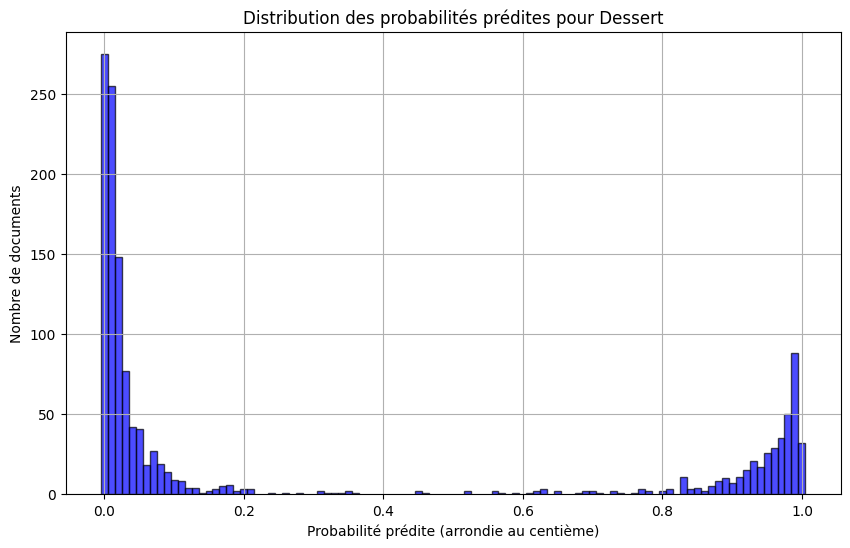

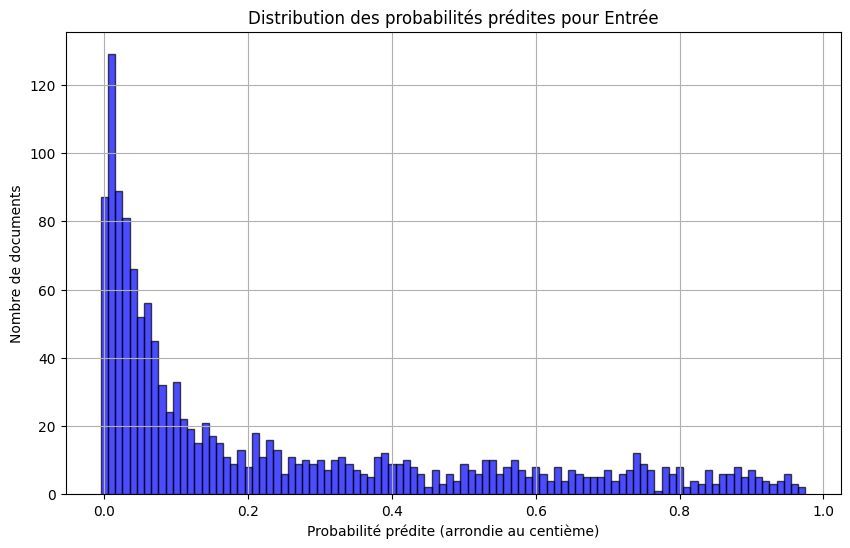

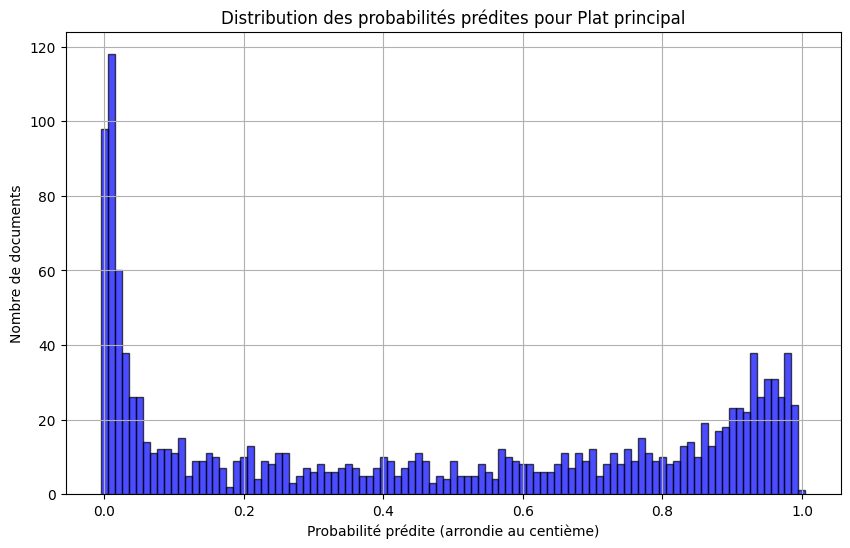

In [81]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Prédire les probabilités pour les données de test
y_prob = rl_model_tf.predict_proba(X_test_tf)

# Nom des classes
class_names = ["Dessert", "Entrée", "Plat principal"]

# Tracer les courbes pour chaque classe
for i, class_name in enumerate(class_names):
    y_prob_rounded = np.round(y_prob[:, i], 2)
    unique_probs, counts = np.unique(y_prob_rounded, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_probs, counts, width=0.01, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Probabilité prédite (arrondie au centième)')
    plt.ylabel('Nombre de documents')
    plt.title(f'Distribution des probabilités prédites pour {class_name}')
    plt.grid(True)
    plt.show()